This notebook contains code that re-downloads the previous training data using the S2Cloudless cloud removal algorithm.

The code in this notebook was largely written by Wendy Mak.

In order to reuse the old labelled data, we need 
1. the new AOI of the rainforest region (s3://canopy-vector-assets/drc_forest_boundary/)
2. the old polygons of where the chips came from (the 'Misha polygons' from https://docs.google.com/spreadsheets/d/1VGC97SZUmMZwPrlmQNihr6VClsUpXfrd/edit?usp=sharing&ouid=112845710244339721982&rtpof=true&sd=true)
3. The old ISL chips on AWS

The steps are 
1. Find the polygons in 2 that intersects with the AOI in 1. 
2. Find the ISL chips that intersections with these polygons
3. Find the bounding box coords of these chips, and redownload them from google earth engine


In [1]:
from cloudpathlib import CloudPath
import rasterio
from pathlib import Path
from rasterio import features as rfeatures
import geopandas as gpd
import pandas as pd
import ee
from shapely.geometry.polygon import Polygon
import json
import os
import numpy as np
import time

import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from datetime import datetime

from typing import List, Union
ee.Initialize()

%matplotlib inline

PROJ: proj_create_from_database: Cannot find proj.db


In [2]:
from cloudpathlib import S3Client

client = S3Client(profile_name='ProjectCanopyMVP')

NameError: name 'Session' is not defined

In [2]:
from s2cloudless_pipeline import S2CloudlessPipeline

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#### Load AOI as geo dataframe

In [2]:
drc_aoi = gpd.read_file('D:/canopy_data/DRC/PC_boundary3/pc_boundary_3.shp')
# change URL to the location of your area of interest on your local machine
print(drc_aoi.crs)
drc_aoi.head()


epsg:4326


,FID,geometry
0,0,"POLYGON ((18.49352 -3.58111, 16.11786 -3.50077..."


#### Load csv of 'Misha polygons' and convert to geopandas dataframe

In [3]:
def geojson_to_shapely_polygon(geojson_str:str):
    geojson_dict = json.loads(geojson_str)
    return Polygon(geojson_dict['coordinates'][0])

In [4]:
# change URL below to the location of the "Misha polygons" file on your local machine
old_polygons = pd.read_csv('D:/canopy_data/csvs/polygons_021521.csv').dropna(subset=['polygon'])
# the 'polygon' column in the csv can be loaded as a geojson, then converted to a shapely polygon
# we set copy to the  'geometry' column for geopandas
old_polygons['geometry'] = old_polygons.polygon.apply(geojson_to_shapely_polygon)
# we also keep a copy of the original 'polygon' column as a dict to be able to cross check if necessary
old_polygons.polygon = old_polygons.polygon.apply(json.loads)
# convert pandas to geopandas df
old_polygons = gpd.GeoDataFrame(old_polygons, geometry='geometry')
# define the crs of the geo dataframe
old_polygons.crs = 'epsg:4326'

In [5]:
old_polygons.head(1).T

,0
image,1
quality?,N
center-lat,5.77459
center-long,9.16861
polygon,"{'type': 'Polygon', 'coordinates': [[[9.088783..."
zoom,@1000m
country,Cameroon
concession,11-003
added on,5-Oct-20
revised on,NaN


#### Find intersection of old polygons with new DRC AOI

In [6]:
# drc_polygons = drc_aoi.sjoin(old_polygons[['image','geometry',  'tile date', 'Labels combined (without additions)']], how='left')
drc_polygons = gpd.sjoin(old_polygons[['image','geometry',  'tile date']], drc_aoi, how='inner')
drc_polygons.head()

,image,geometry,tile date,index_right,FID
48,49,"POLYGON ((20.22892 2.45607, 20.05554 2.35007, ...",10-Mar-20,0,0
49,50,"POLYGON ((20.20798 2.36619, 20.36076 2.41730, ...",10-Mar-20,0,0
50,51,"POLYGON ((20.76459 2.39835, 20.78476 2.39767, ...",10-Mar-20,0,0
51,52,"POLYGON ((20.34788 2.40273, 20.70820 2.38197, ...",10-Mar-20,0,0
53,54,"POLYGON ((20.93488 2.29004, 20.92097 2.33309, ...",10-Mar-20,0,0


<AxesSubplot:>

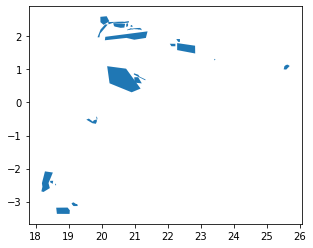

In [7]:
drc_polygons.plot()

In [8]:
print(f"there are {len(drc_polygons)} out of {len(old_polygons)} polygons in the new AOI")

there are 24 out of 97 polygons in the new AOI


#### Download labelled chips from s3

The code below downloads all relevant labelled chips from S3 to your local machine. Make sure to change the local directoreis to wherever you want the chips to go.

In [12]:
s3_datapath = CloudPath("s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/", client=client)   

In [13]:
isl_datapath =  s3_datapath / 'ISL'
isl_datalist = list(isl_datapath.glob("**/*.tif"))
isl_datalist[:5]

[S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/ISL/100/1/1_1000_1000.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/ISL/100/1/1_1000_900.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/ISL/100/1/1_100_900.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/ISL/100/1/1_1100_1000.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/ISL/100/1/1_1100_1100.tif')]

In [14]:
industrial_agriculture_datapath =  s3_datapath / 'Industrial_agriculture/'
industrial_agricultur_datalist = list(industrial_agriculture_datapath.glob("**/*.tif"))
industrial_agricultur_datalist[:5]

[S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Industrial_agriculture/100/10/10_1000_2300.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Industrial_agriculture/100/10/10_1000_2400.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Industrial_agriculture/100/10/10_1000_2500.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Industrial_agriculture/100/10/10_1100_2200.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Industrial_agriculture/100/10/10_1100_2300.tif')]

In [16]:
slash_and_burn_datapath = s3_datapath / 'Shifting_cultivation/'
slash_and_burn_datapath = list(slash_and_burn_datapath.glob("**/*.tif"))
slash_and_burn_datapath[:5]

[S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Shifting_cultivation/100/10/10_1000_2500.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Shifting_cultivation/100/10/10_1000_2600.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Shifting_cultivation/100/10/10_1000_2700.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Shifting_cultivation/100/10/10_1100_2500.tif'),
 S3Path('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/Shifting_cultivation/100/10/10_1100_2600.tif')]

In [17]:
null_chips = list((s3_datapath / 'misc/').glob("**/*.tif")) 

In [11]:
isl_chips_local_dir = Path('data/isl_chips')
industrial_agricultur_dir = Path('data/industrial_agri_chips')
sab_dir = Path('data/slash_and_burn_chips')
# null_dir = Path('data/null_chips')

# isl_chips_local_dir.mkdir(exist_ok=True)
# industrial_agricultur_dir.mkdir(exist_ok=True)
# sab_dir.mkdir(exist_ok=True)
# null_dir.mkdir(exist_ok=True)

In [34]:
for file in isl_datalist:
    
    filename = str(file).replace('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/', '').replace('/', '-')
    local_filepath =str(isl_chips_local_dir/filename)
    if not local_filepath.is_file():
        file.download_to(str(local_filepath))

In [35]:
for file in industrial_agricultur_datalist:
    filename = str(file).replace('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/', '').replace('/', '-')
    local_filepath =str(industrial_agricultur_dir/filename)
    if not local_filepath.is_file():
        file.download_to(str(local_filepath))

In [19]:
for file in slash_and_burn_datapath:
    # 3900 chips
    filename = str(file).replace('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/', '').replace('/', '-')
    local_filepath =str(sab_dir/filename)
    if not sab_dir.is_file():
        file.download_to(str(local_filepath))

In [20]:
for file in null_chips:
    
    filename = str(file).replace('s3://canopy-production-ml/chips/cloudfree-merge-polygons/dataset_v2/', '').replace('/', '-')
    local_filepath =str(null_dir/filename)
    if not null_dir.is_file():
        file.download_to(str(local_filepath))

KeyboardInterrupt: 

In [24]:
import glob
tile_list = []
local_dir = 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100/'
file_list = glob.glob(local_dir + '*/*')
for file in file_list:
    if file.endswith('.tif'):
        tmp_data = rasterio.open(file)
        crs = tmp_data.crs
        xmin, ymin, xmax, ymax = tmp_data.bounds
        tile_list.append(dict(polygon_id=Path(file).stem, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, projection=str(crs), evenOdd=False, label='sab'))
    
# for file in os.listdir(null_dir):
#     if file.endswith('.tif'):
#         tmp_data = rasterio.open(null_dir/file)
#         crs = tmp_data.crs
#         xmin, ymin, xmax, ymax = tmp_data.bounds
#         tile_list.append(dict(polygon_id=Path(file).stem, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, projection=str(crs), evenOdd=False, label='null'))
    
tile_df = pd.DataFrame(tile_list)
tile_df.to_csv('labels_and_boundaries_sab.csv', index=False)

In [21]:
local_dir = 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100/'
import glob

glob.glob(local_dir + '*/*')[:10]

['D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_0.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_100.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1000.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1100.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1200.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1300.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1400.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1500.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1600.tif',
 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_1700.tif']

In [22]:
f = 'D:/canopy_data/s2cloudless_new_model/old_chips/null/100\\1\\1_0_0.tif'
tmp_data = rasterio.open(f)
crs = tmp_data.crs
xmin, ymin, xmax, ymax = tmp_data.bounds

In [23]:
xmin

-11373545.265760867

In [32]:
crs

In [35]:
tmp_data.bounds

BoundingBox(left=-10636308.984777253, bottom=-4147848.1965435157, right=-10634590.15695737, top=-4146129.3687236323)

In [16]:
# tile_list = []
# for file in os.listdir(isl_chips_local_dir):
#     if file.endswith('.tif'):
#         tmp_data = rasterio.open(isl_chips_local_dir/file)
#         crs = tmp_data.crs
#         xmin, ymin, xmax, ymax = tmp_data.bounds
#         tile_list.append(dict(polygon_id=Path(file).stem, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, projection=str(crs), evenOdd=False, label='isl'))
    
# for file in os.listdir(industrial_agricultur_dir):
#     if file.endswith('.tif'):
#         tmp_data = rasterio.open(industrial_agricultur_dir/file)
#         crs = tmp_data.crs
#         xmin, ymin, xmax, ymax = tmp_data.bounds
#         tile_list.append(dict(polygon_id=Path(file).stem, xmin=xmin, ymin=ymin, xmax=xmax, ymax=ymax, projection=str(crs), evenOdd=False, label='industrial_agriculture'))
    
# tile_df = pd.DataFrame(tile_list)

In [41]:
# tile_df.to_csv('data/labels_and_boundaries.csv', index=False)

In [25]:
# assert len(tile_df) == len(isl_datalist) + len(industrial_agricultur_datalist)
#assert tile_df.projection.nunique() ==1

len(tile_df)

114967

## Make dataframe that contains label information

Should be able to run this code as-is with the `labels_and_boundaries_sab.csv` file in this folder.

In [9]:
tile_df = pd.read_csv('labels_and_boundaries_sab.csv')
# tile_df = pd.read_csv('data/labels_and_boundaries.csv')
tile_df['geometry'] = tile_df.apply(lambda row: Polygon([(row.xmin, row.ymin), (row.xmax, row.ymin), (row.xmax, row.ymax), (row.xmin, row.ymax)]), axis=1)
tile_df.head(1).T

,0
polygon_id,1_0_0
xmin,-11373545.265761
ymin,-6790278.623185
xmax,-11371551.373951
ymax,-6788284.731375
projection,None
evenOdd,False
label,sab
geometry,POLYGON ((-11373545.26576087 -6790278.62318496...


In [10]:
assert tile_df.polygon_id.nunique() == len(tile_df)

In [11]:
tile_df.projection.values

array(['None', 'None', 'None', ..., 'None', 'None', 'None'], dtype=object)

In [12]:
tile_gdf =gpd.GeoDataFrame( tile_df[['polygon_id', 'geometry', 'label']], geometry='geometry', crs='EPSG:3257').to_crs('epsg:4326')

<AxesSubplot:>

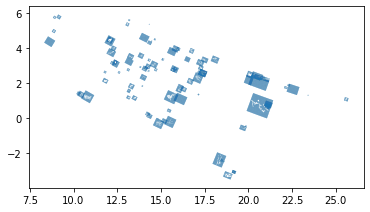

In [13]:
tile_gdf.plot()

In [14]:
# tile_gdf_combo = drc_polygons[['image','geometry',  'tile date', 'Labels combined (without additions)']].sjoin(tile_gdf, how='left').drop_duplicates(subset=['polygon_id'])
tile_gdf_combo = gpd.sjoin(tile_gdf, drc_polygons[['image','geometry',  'tile date']], how='inner').drop_duplicates(subset=['polygon_id'])
# get xmin, xmax etc for calling s2cloudless below
bounds = tile_gdf_combo.geometry.bounds
tile_gdf_combo['xmin'] = bounds.minx
tile_gdf_combo['xmax'] = bounds.maxx
tile_gdf_combo['ymin'] = bounds.miny
tile_gdf_combo['ymax'] = bounds.maxy

tile_gdf_combo.shape, tile_gdf.shape

((15823, 10), (114967, 3))

In [15]:
tile_gdf_combo.head()

,polygon_id,geometry,label,index_right,image,tile date,xmin,xmax,ymin,ymax
2785,100_1000_0,"POLYGON ((19.23545 -3.13054, 19.23219 -3.13895...",sab,94,99,12-Aug-20,19.232189,19.243817,-3.142230,-3.130542
2786,100_1000_100,"POLYGON ((19.22708 -3.12726, 19.22382 -3.13567...",sab,94,99,12-Aug-20,19.223822,19.235450,-3.138953,-3.127264
2787,100_1000_1000,"POLYGON ((19.15183 -3.09772, 19.14856 -3.10612...",sab,94,99,12-Aug-20,19.148559,19.160187,-3.109407,-3.097718
2788,100_1000_1200,"POLYGON ((19.13512 -3.09114, 19.13184 -3.09954...",sab,94,99,12-Aug-20,19.131844,19.143473,-3.102831,-3.091141
2789,100_1000_1300,"POLYGON ((19.12676 -3.08785, 19.12349 -3.09625...",sab,94,99,12-Aug-20,19.123488,19.135116,-3.099541,-3.087851


In [16]:
# sanity check the label counts
tile_gdf_combo.label.value_counts()

sab    15823
Name: label, dtype: int64

In [17]:
tile_gdf_combo['polygon_id'].value_counts()

100_1000_0      1
81_4400_9300    1
81_4400_9500    1
81_4400_9600    1
81_4400_9700    1
               ..
60_4500_6700    1
60_4500_6800    1
60_4500_6900    1
60_4500_7000    1
94_600_0        1
Name: polygon_id, Length: 15823, dtype: int64

### S2 cloudless downloads

This code re-downloads the labeled tiles using the S2Cloudless algorithm.

In [18]:
import glob

chips = glob.glob('D:/canopy_data/s2cloudless_new_model/null/*/*.tif')

chips[0]

'D:/canopy_data/s2cloudless_new_model/null\\s2cloudless_null_chips\\100_1000_0.tif'

In [19]:
chips[0].split('\\')[-1][:-4]

'100_1000_0'

In [20]:
dup_poly_ids = [c.split('\\')[-1][:-4] for c in chips]

dup_poly_ids[:10]

['100_1000_0',
 '100_1000_100',
 '100_1000_1000',
 '100_1000_1200',
 '100_1000_1300',
 '100_1000_1400',
 '100_1000_1600',
 '100_1000_200',
 '100_1000_300',
 '100_1000_400']

In [21]:
dup_poly_ids[-10:]

['82_900_1800',
 '82_900_2000',
 '82_900_2300',
 '82_900_2400',
 '82_900_2500',
 '82_900_2600',
 '82_900_2700',
 '82_900_2800',
 '82_900_2900',
 '82_900_3000']

In [22]:
tile_gdf_combo.head()

,polygon_id,geometry,label,index_right,image,tile date,xmin,xmax,ymin,ymax
2785,100_1000_0,"POLYGON ((19.23545 -3.13054, 19.23219 -3.13895...",sab,94,99,12-Aug-20,19.232189,19.243817,-3.142230,-3.130542
2786,100_1000_100,"POLYGON ((19.22708 -3.12726, 19.22382 -3.13567...",sab,94,99,12-Aug-20,19.223822,19.235450,-3.138953,-3.127264
2787,100_1000_1000,"POLYGON ((19.15183 -3.09772, 19.14856 -3.10612...",sab,94,99,12-Aug-20,19.148559,19.160187,-3.109407,-3.097718
2788,100_1000_1200,"POLYGON ((19.13512 -3.09114, 19.13184 -3.09954...",sab,94,99,12-Aug-20,19.131844,19.143473,-3.102831,-3.091141
2789,100_1000_1300,"POLYGON ((19.12676 -3.08785, 19.12349 -3.09625...",sab,94,99,12-Aug-20,19.123488,19.135116,-3.099541,-3.087851


In [23]:
tile_gdf_combo.loc[2785, 'polygon_id']

'100_1000_0'

In [24]:
# The below values can be changed if you think different ones would work better
DEFAULT_START_DATE = '2020-12-15'
DEFAULT_END_DATE = '2021-03-15'
NUM_MONTHS = 2 # we want the place the old download date at the middle of ther range
CLOUD_FILTER = 20
CLD_PRB_THRESH = 20
NIR_DRK_THRESH = 0.15
CLD_PRJ_DIST = 1
BUFFER = 25
band_list = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','TCI_R','TCI_G','TCI_B','AOT','WVP']

In [25]:
tile_gdf_combo.shape

(15823, 10)

In [26]:
from s2cloudless_pipeline import S2CloudlessPipeline

In [27]:
tasks_lists = []
tile_gdf_combo['tile date'] = pd.to_datetime(tile_gdf_combo['tile date'], format='%d-%b-%y')
pipelines = []

for curr_date in tile_gdf_combo['tile date'].unique():
    tiles = tile_gdf_combo[tile_gdf_combo['tile date'] == curr_date][['polygon_id', 'xmin', 'xmax', 'ymin', 'ymax', 'geometry']]
    tiles_json_string = tiles.to_json()
    tiles_dict = json.loads(tiles_json_string)
    tile_list = []
    
    if len(tasks_lists) > 2000:
        time.sleep(10 * 60)
    
    for entry in tiles_dict['features']:
        polygon_id = entry['properties']['polygon_id']
        xmin = entry['properties']['xmin']
        xmax = entry['properties']['xmax']
        ymin = entry['properties']['ymin']
        ymax = entry['properties']['ymax']
        tile_list.append(dict(polygon_id=polygon_id, aoi=ee.Geometry.Rectangle(coords=ee.List([xmin, ymin, xmax, ymax ]), proj=str(tile_gdf_combo.crs), evenOdd=False)))
    
    start_date = (curr_date - pd.Timedelta('45days')).strftime('%Y-%m-%d')
    end_date = (curr_date + pd.Timedelta('45days')).strftime('%Y-%m-%d')
    
    if not datetime.utcfromtimestamp(curr_date.tolist()/1e9).month in [12, 1,2]:
        print(curr_date, 'using defaults')
        start_date = DEFAULT_START_DATE
        end_date = DEFAULT_END_DATE
    pipeline = S2CloudlessPipeline(
        s2cloudless_config=dict(CLOUD_FILTER =CLOUD_FILTER,
        CLD_PRB_THRESH =CLD_PRB_THRESH,
        NIR_DRK_THRESH =NIR_DRK_THRESH,
        CLD_PRJ_DIST =CLD_PRJ_DIST, BUFFER=BUFFER), chips_list=tile_list
    )
    pipelines.append(pipeline)
    
#     tasks = pipeline.s2cloudless_process_download(start_date=start_date, end_date=end_date, folder='project-canopy-sab')
#     tasks_lists.append(tasks)

2020-08-12T00:00:00.000000000 using defaults
2020-04-14T00:00:00.000000000 using defaults
2020-03-10T00:00:00.000000000 using defaults


In [35]:
pipelines

In [28]:
for i, p in enumerate(pipelines):
    print(f'Downloading pipleine {i} of {len(pipelines)}')
    tasks = p.s2cloudless_process_download(start_date=start_date, end_date=end_date, dup_ids=dup_poly_ids)
    if i >= 2:
        time.sleep(3600) # There's a maximum limit to the number of GEE downloads at any given time,
                         # so I had it pause after each pipeline in an effor to not exceed that limit.

100%|███████████████████████████████████████████████████████████████████████████| 1670/1670 [00:00<00:00, 32102.11it/s]


100%|███████████████████████████████████████████████████████████████████████████| 6751/6751 [00:00<00:00, 13489.00it/s]


100%|████████████████████████████████████████████████████████████████████████████| 5156/5156 [7:17:20<00:00,  5.09s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 154/154 [00:47<00:00,  3.23it/s]


100%|████████████████████████████████████████████████████████████████████████████| 1713/1713 [3:08:19<00:00,  6.60s/it]


100%|████████████████████████████████████████████████████████████████████████████████| 119/119 [00:35<00:00,  3.32it/s]


100%|████████████████████████████████████████████████████████████████████████████████| 260/260 [01:15<00:00,  3.47it/s]


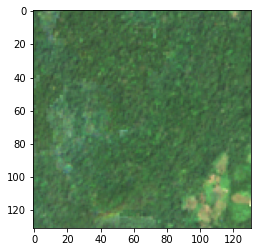

<AxesSubplot:>

In [30]:
dataset = rasterio.open(f'/home/wwymak/Downloads/Shifting_cultivation-100-101-101_500_2000-2019-12-01-2020-02-29.tif')
arr = dataset.read([4,3,2]) 
show(arr/arr.max())

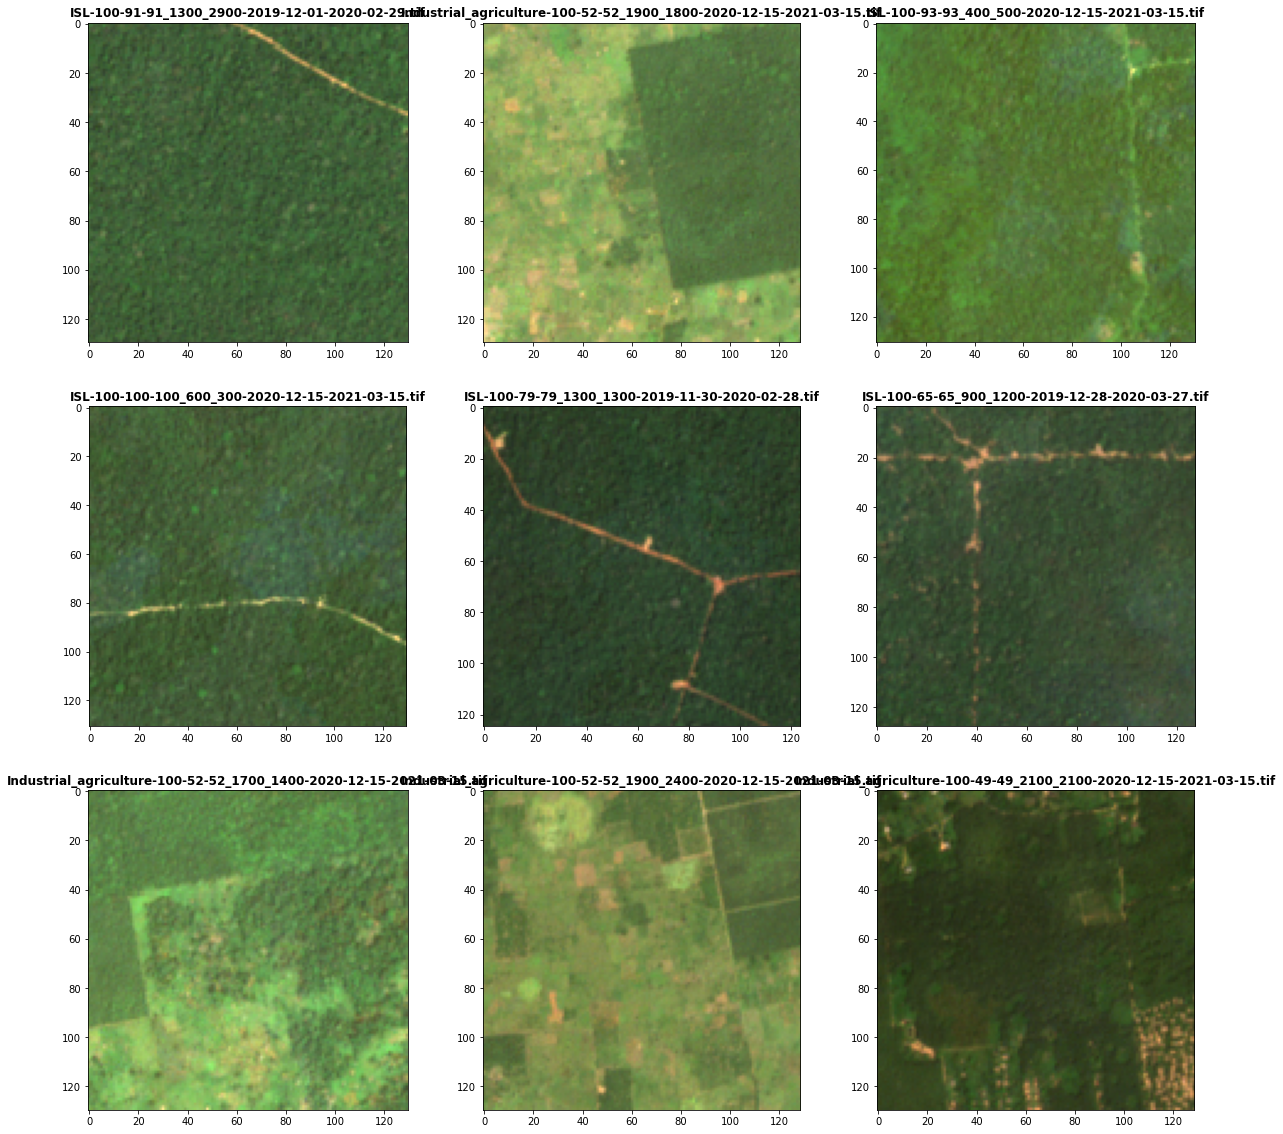

In [9]:
# do a manual check of some random samples
chips = os.listdir('data/s2cloudless-old-chips')

fnames = np.random.choice(chips, size=9, replace=False)
f, ax = plt.subplots(3,3, figsize = (20, 20))
axs = ax.ravel()

for idx, fname in enumerate(fnames):

    dataset = rasterio.open(f'data/s2cloudless-old-chips/{fname}')
    arr = dataset.read([4,3,2]) 
    show(arr/arr.max(),ax=axs[idx], title=fname)

In [18]:
# CLOUD_FILTER = 60
# CLD_PRB_THRESH = 40
# NIR_DRK_THRESH = 0.15
# CLD_PRJ_DIST = 2

# # CLOUD_FILTER = 80
# # CLD_PRB_THRESH = 50
# # NIR_DRK_THRESH = 0.15
# # CLD_PRJ_DIST = 0.5

# BUFFER = 50
# BUFFER = 100
# band_list = ['B1','B2','B3','B4','B5','B6','B7','B8','B8A','B9','B11','B12','TCI_R','TCI_G','TCI_B','AOT','WVP']

# data_dir = Path('data')

In [31]:
# natural_earth_data = gpd.read_file(data_dir / 'ne_10m_admin_0_countries.zip')
# drc_gdf = natural_earth_data[natural_earth_data.ADMIN.apply(lambda x: ('congo' in x.lower() and 'democratic' in x.lower()))]
# drc_gdf.head()

In [32]:
# the info we want is in the geometry column
# we also want to read in the polygon info to find the ones we want
# old_polygons = pd.read_csv(data_dir / 'old_polygons_2021.csv').dropna(subset=['polygon'])
# old_polygons = old_polygons[old_polygons['area (km2)'] > 500]
# old_polygons.columns

In [33]:
# old_polygons['geometry'] = old_polygons.polygon.apply(geojson_to_shapely_polygon)
# old_polygons.polygon = old_polygons.polygon.apply(json.loads)
# old_polygons = gpd.GeoDataFrame(old_polygons, geometry='geometry')
# old_polygons.crs = 'epsg:4326'



# drc_polygons = drc_gdf[['ADMIN','geometry']].sjoin(old_polygons[['image','geometry', 'polygon', 'area (km2)']], how='left')
# drc_polygons.head()

In [28]:
# for idx, poly in enumerate(drc_polygons["polygon"].values):
#     coordinates = poly["coordinates"]
#     print(idx, len(coordinates[0]), coordinates[0])

In [13]:
# # Import the folium library.
# import folium

# # Define a method for displaying Earth Engine image tiles to a folium map.
# def add_ee_layer(self, ee_image_object, vis_params, name, show=True, opacity=1, min_zoom=0):
#     map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
#     folium.raster_layers.TileLayer(
#         tiles=map_id_dict['tile_fetcher'].url_format,
#         attr='Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
#         name=name,
#         show=show,
#         opacity=opacity,
#         min_zoom=min_zoom,
#         overlay=True,
#         control=True
#         ).add_to(self)

# # Add the Earth Engine layer method to folium.
# folium.Map.add_ee_layer = add_ee_layer

# def display_cloud_layers(col):
#     # Mosaic the image collection.
#     img = col.mosaic()

#     # Subset layers and prepare them for display.
#     clouds = img.select('clouds').selfMask()
#     shadows = img.select('shadows').selfMask()
#     dark_pixels = img.select('dark_pixels').selfMask()
#     probability = img.select('probability')
#     cloudmask = img.select('cloudmask').selfMask()
#     cloud_transform = img.select('cloud_transform')

#     # Create a folium map object.
#     center = AOI.centroid(10).coordinates().reverse().getInfo()
#     m = folium.Map(location=center, zoom_start=12)

#     # Add layers to the folium map.
#     m.add_ee_layer(img,
#                    {'bands': ['B4', 'B3', 'B2'], 'min': 0, 'max': 2500, 'gamma': 1.1},
#                    'S2 image', True, 1, 9)
#     m.add_ee_layer(probability,
#                    {'min': 0, 'max': 100},
#                    'probability (cloud)', False, 1, 9)
#     m.add_ee_layer(clouds,
#                    {'palette': 'e056fd'},
#                    'clouds', False, 1, 9)
#     m.add_ee_layer(cloud_transform,
#                    {'min': 0, 'max': 1, 'palette': ['white', 'black']},
#                    'cloud_transform', False, 1, 9)
#     m.add_ee_layer(dark_pixels,
#                    {'palette': 'orange'},
#                    'dark_pixels', False, 1, 9)
#     m.add_ee_layer(shadows, {'palette': 'yellow'},
#                    'shadows', False, 1, 9)
#     m.add_ee_layer(cloudmask, {'palette': 'orange'},
#                    'cloudmask', True, 0.5, 9)

#     # Add a layer control panel to the map.
#     m.add_child(folium.LayerControl())

#     # Display the map.
#     display(m)

In [11]:
# poly_collection = gdf_to_ee_feature_collection(drc_polygons)

In [12]:
# AOI = ee.Geometry.Polygon(coords=[
#     [[20.107727, 1.98744], [21.386261, 2.152814], [21.334763, 1.953814], [20.983887, 1.898914], [20.748367, 1.954501], [20.093994, 1.882443], [20.107727, 1.98744]]
# ])
# START_DATE='2021-01-01'
# END_DATE='2021-03-01'
# s2_sr_cld_col_eval = get_s2_sr_cld_col(AOI, START_DATE, END_DATE)
# s2_sr_cld_col_eval_disp = s2_sr_cld_col_eval.map(add_cld_shdw_mask)

# display_cloud_layers(s2_sr_cld_col_eval_disp)